In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [1]:
data_path = '/content/Brain Tumor.csvt'


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load dataset
df = pd.read_csv('/content/Brain Tumor.csv')

# Display first few rows
print(df.head())

# Separate features and labels
X = df.drop(['Image', 'Class'], axis=1)
y = df['Class']

# Split dataset into train and test sets (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


    Image  Class      Mean     Variance  Standard Deviation   Entropy  \
0  Image1      0  6.535339   619.587845           24.891522  0.109059   
1  Image2      0  8.749969   805.957634           28.389393  0.266538   
2  Image3      1  7.341095  1143.808219           33.820234  0.001467   
3  Image4      1  5.958145   959.711985           30.979219  0.001477   
4  Image5      0  7.315231   729.540579           27.010009  0.146761   

   Skewness   Kurtosis    Contrast    Energy       ASM  Homogeneity  \
0  4.276477  18.900575   98.613971  0.293314  0.086033     0.530941   
1  3.718116  14.464618   63.858816  0.475051  0.225674     0.651352   
2  5.061750  26.479563   81.867206  0.031917  0.001019     0.268275   
3  5.677977  33.428845  151.229741  0.032024  0.001026     0.243851   
4  4.283221  19.079108  174.988756  0.343849  0.118232     0.501140   

   Dissimilarity  Correlation     Coarseness  
0       4.473346     0.981939  7.458341e-155  
1       3.220072     0.988834  7.458341e

In [3]:
import numpy as np

class ELM:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.input_weights = np.random.randn(self.input_size, self.hidden_size)
        self.bias = np.random.randn(self.hidden_size)
        self.output_weights = None
        self.one_hot = False
        self.classes = None

    def _activation(self, x):
        return 1 / (1 + np.exp(-x))  # Sigmoid activation

    def fit(self, X, y):
        # One-hot encode y if multi-class
        if len(np.unique(y)) > 2:
            self.one_hot = True
            self.classes = np.unique(y)
            y_onehot = np.zeros((y.shape[0], len(self.classes)))
            for i, label in enumerate(y):
                y_onehot[i, np.where(self.classes == label)[0][0]] = 1
            y = y_onehot
        else:
            self.one_hot = False
            y = np.array(y).reshape(-1, 1)  # FIXED HERE

        H = self._activation(np.dot(X, self.input_weights) + self.bias)
        self.output_weights = np.dot(np.linalg.pinv(H), y)

    def predict(self, X):
        H = self._activation(np.dot(X, self.input_weights) + self.bias)
        y_pred = np.dot(H, self.output_weights)
        if self.one_hot:
            return self.classes[np.argmax(y_pred, axis=1)]
        else:
            return (y_pred > 0.5).astype(int).flatten()

# Initialize and train ELM
elm = ELM(input_size=X_train.shape[1], hidden_size=100, output_size=1)
elm.fit(X_train, y_train)

# Predict on test set
y_pred_elm = elm.predict(X_test)

# Accuracy
from sklearn.metrics import accuracy_score
elm_accuracy = accuracy_score(y_test, y_pred_elm)
print("ELM Accuracy:", elm_accuracy)


ELM Accuracy: 0.9800796812749004


In [4]:
from sklearn.tree import DecisionTreeClassifier

# Train decision tree classifier with default params
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# Predict on test set
y_pred_dt = dt.predict(X_test)

# 2. ELM (Baseline)
elm = ELM(input_size=X_train.shape[1], hidden_size=100, output_size=1)
elm.fit(X_train, y_train)
y_pred_elm = elm.predict(X_test)

# Evaluate
print("Decision Tree Accuracy (Baseline):", accuracy_score(y_test, y_pred_dt))
print("ELM Accuracy (Baseline):", accuracy_score(y_test, y_pred_elm))
print(classification_report(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_elm))


Decision Tree Accuracy (Baseline): 0.9747675962815405
ELM Accuracy (Baseline): 0.9721115537848606
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       419
           1       0.98      0.96      0.97       334

    accuracy                           0.97       753
   macro avg       0.98      0.97      0.97       753
weighted avg       0.97      0.97      0.97       753

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       419
           1       0.97      0.96      0.97       334

    accuracy                           0.97       753
   macro avg       0.97      0.97      0.97       753
weighted avg       0.97      0.97      0.97       753



In [5]:
from sklearn.model_selection import cross_val_score

def dt_objective(params):
    max_depth, min_samples_split = params
    max_depth = int(max_depth)
    min_samples_split = int(min_samples_split)

    dt = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, random_state=42)
    scores = cross_val_score(dt, X_train, y_train, cv=5, scoring='accuracy')
    # Return negative accuracy as we minimize
    return -scores.mean()


In [6]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

def fitness_function_hba(params, X_train, y_train, X_val, y_val):
    max_depth = int(params[0])
    min_samples_split = int(params[1])

    if max_depth < 1: max_depth = 1
    if min_samples_split < 2: min_samples_split = 2

    clf = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    return 1 - accuracy_score(y_val, y_pred)  # Lower is better

def honey_badger_algorithm(X_train, y_train, X_val, y_val, n_agents=10, max_iter=20):
    dim = 2
    lb = np.array([1, 2])
    ub = np.array([20, 20])

    # Initialize agents as float for operations
    agents = np.random.randint(low=lb, high=ub + 1, size=(n_agents, dim)).astype(float)
    best_fitness = float("inf")
    best_position = None

    for iter in range(max_iter):
        alpha = 2 * np.exp(-4 * (iter / max_iter) ** 2)
        for i in range(n_agents):
            fitness = fitness_function_hba(agents[i], X_train, y_train, X_val, y_val)
            if fitness < best_fitness:
                best_fitness = fitness
                best_position = agents[i].copy()

        for i in range(n_agents):
            F = alpha * np.random.rand()
            rand_agent = agents[np.random.randint(n_agents)]
            if np.random.rand() < 0.5:
                agents[i] += F * (rand_agent - agents[i])
            else:
                agents[i] -= F * (rand_agent - agents[i])
            # Clamp within bounds
            agents[i] = np.clip(agents[i], lb, ub)

    return best_position.astype(int)

# Train-validation split
X_sub_train, X_val, y_sub_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Run HBA optimizer
best_params_hba = honey_badger_algorithm(X_sub_train, y_sub_train, X_val, y_val)
print("Best HBA Parameters (max_depth, min_samples_split):", best_params_hba)

# Train final Decision Tree using best parameters
clf_hba = DecisionTreeClassifier(max_depth=best_params_hba[0], min_samples_split=best_params_hba[1])
clf_hba.fit(X_train, y_train)
y_pred_hba = clf_hba.predict(X_test)

# Accuracy
hba_accuracy = accuracy_score(y_test, y_pred_hba)
print("HBA-Optimized Decision Tree Accuracy:", hba_accuracy)


Best HBA Parameters (max_depth, min_samples_split): [6 2]
HBA-Optimized Decision Tree Accuracy: 0.9787516600265604


In [7]:
best_max_depth = int(best_params_hba[0])
best_min_samples_split = int(best_params_hba[1])

dt_hba = DecisionTreeClassifier(max_depth=best_max_depth, min_samples_split=best_min_samples_split, random_state=42)
dt_hba.fit(X_train, y_train)

y_pred_hba = dt_hba.predict(X_test)

print("Optimized Decision Tree Accuracy (HBA):", accuracy_score(y_test, y_pred_hba))
print(classification_report(y_test, y_pred_hba))


Optimized Decision Tree Accuracy (HBA): 0.9774236387782205
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       419
           1       0.99      0.96      0.97       334

    accuracy                           0.98       753
   macro avg       0.98      0.98      0.98       753
weighted avg       0.98      0.98      0.98       753



In [8]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

def fitness_function_ssa(params, X_train, y_train, X_val, y_val):
    max_depth = int(params[0])
    min_samples_split = int(params[1])

    if max_depth < 1: max_depth = 1
    if min_samples_split < 2: min_samples_split = 2

    clf = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    return 1 - accuracy_score(y_val, y_pred)  # Lower is better

def salp_swarm_algorithm(X_train, y_train, X_val, y_val, n_salps=10, max_iter=20):
    dim = 2
    lb = np.array([1, 2])
    ub = np.array([20, 20])

    # Initialize salps as float
    salps = np.random.randint(lb[0], ub[0] + 1, size=(n_salps, dim)).astype(float)
    food_position = None
    food_fitness = float("inf")

    for iter in range(max_iter):
        c1 = 2 * np.exp(-(4 * iter / max_iter) ** 2)  # convergence factor

        for i in range(n_salps):
            fitness = fitness_function_ssa(salps[i], X_train, y_train, X_val, y_val)
            if fitness < food_fitness:
                food_fitness = fitness
                food_position = salps[i].copy()

        for i in range(n_salps):
            for j in range(dim):
                if i == 0:  # leader
                    c2 = np.random.rand()
                    c3 = np.random.rand()
                    if c3 < 0.5:
                        salps[i, j] = food_position[j] + c1 * ((ub[j] - lb[j]) * c2 + lb[j])
                    else:
                        salps[i, j] = food_position[j] - c1 * ((ub[j] - lb[j]) * c2 + lb[j])
                else:  # followers
                    salps[i, j] = (salps[i, j] + salps[i - 1, j]) / 2.0

            # Clamp to bounds
            salps[i] = np.clip(salps[i], lb, ub)

    return food_position.astype(int)

# Train-validation split
X_sub_train, X_val, y_sub_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Run SSA optimizer
best_params_ssa = salp_swarm_algorithm(X_sub_train, y_sub_train, X_val, y_val)
print("Best SSA Parameters (max_depth, min_samples_split):", best_params_ssa)

# Train final Decision Tree using best SSA parameters
clf_ssa = DecisionTreeClassifier(max_depth=best_params_ssa[0], min_samples_split=best_params_ssa[1])
clf_ssa.fit(X_train, y_train)
y_pred_ssa = clf_ssa.predict(X_test)

# Accuracy
ssa_accuracy = accuracy_score(y_test, y_pred_ssa)
print("SSA-Optimized Decision Tree Accuracy:", ssa_accuracy)


Best SSA Parameters (max_depth, min_samples_split): [6 4]
SSA-Optimized Decision Tree Accuracy: 0.9774236387782205


In [9]:
def fitness_function_elm(hidden_size, X_train, y_train, X_val, y_val):
    hidden_size = int(hidden_size[0])
    hidden_size = max(1, min(hidden_size, 500))
    elm = ELM(input_size=X_train.shape[1], hidden_size=hidden_size, output_size=1)
    elm.fit(X_train, y_train)
    y_pred = elm.predict(X_val)
    return 1 - accuracy_score(y_val, y_pred)

def honey_badger_elm(X_train, y_train, X_val, y_val, n_agents=10, max_iter=20):
    lb = np.array([10])
    ub = np.array([500])
    agents = np.random.randint(low=lb, high=ub + 1, size=(n_agents, 1)).astype(float)
    best_fitness = float("inf")
    best_position = None
    for iter in range(max_iter):
        alpha = 2 * np.exp(-4 * (iter / max_iter) ** 2)
        for i in range(n_agents):
            fitness = fitness_function_elm(agents[i], X_train, y_train, X_val, y_val)
            if fitness < best_fitness:
                best_fitness = fitness
                best_position = agents[i].copy()
        for i in range(n_agents):
            F = alpha * np.random.rand()
            rand_agent = agents[np.random.randint(n_agents)]
            if np.random.rand() < 0.5:
                agents[i] += F * (rand_agent - agents[i])
            else:
                agents[i] -= F * (rand_agent - agents[i])
            agents[i] = np.clip(agents[i], lb, ub)
    return int(best_position[0])

    # ELM-HBA
best_hidden_hba = honey_badger_elm(X_sub_train, y_sub_train, X_val, y_val)
elm_hba = ELM(input_size=X_train.shape[1], hidden_size=best_hidden_hba, output_size=1)
elm_hba.fit(X_train, y_train)
y_pred_elm_hba = elm_hba.predict(X_test)
elm_hba_acc = accuracy_score(y_test, y_pred_elm_hba)
print("Optimized ELM  (HBA):", accuracy_score(y_test, y_pred_elm_hba))
print(classification_report(y_test, y_pred_elm_hba))

def salp_swarm_elm(X_train, y_train, X_val, y_val, n_salps=10, max_iter=20):
    lb = np.array([10])
    ub = np.array([500])
    salps = np.random.randint(lb[0], ub[0] + 1, size=(n_salps, 1)).astype(float)
    food_position = None
    food_fitness = float("inf")
    for iter in range(max_iter):
        c1 = 2 * np.exp(-(4 * iter / max_iter) ** 2)
        for i in range(n_salps):
            fitness = fitness_function_elm(salps[i], X_train, y_train, X_val, y_val)
            if fitness < food_fitness:
                food_fitness = fitness
                food_position = salps[i].copy()
        for i in range(n_salps):
            for j in range(1):
                if i == 0:
                    c2 = np.random.rand()
                    c3 = np.random.rand()
                    if c3 < 0.5:
                        salps[i, j] = food_position[j] + c1 * ((ub[j] - lb[j]) * c2 + lb[j])
                    else:
                        salps[i, j] = food_position[j] - c1 * ((ub[j] - lb[j]) * c2 + lb[j])
                else:
                    salps[i, j] = (salps[i, j] + salps[i - 1, j]) / 2.0
            salps[i] = np.clip(salps[i], lb, ub)
    return int(food_position[0])

    # ELM-SSA
best_hidden_ssa = salp_swarm_elm(X_sub_train, y_sub_train, X_val, y_val)
elm_ssa = ELM(input_size=X_train.shape[1], hidden_size=best_hidden_ssa, output_size=1)
elm_ssa.fit(X_train, y_train)
y_pred_elm_ssa = elm_ssa.predict(X_test)
elm_ssa_acc = accuracy_score(y_test, y_pred_elm_ssa)
print("Optimized ELM (SSA):", accuracy_score(y_test, y_pred_elm_ssa))
print(classification_report(y_test, y_pred_elm_ssa))
print(f"Best ELM Hidden Neurons (HBA): {best_hidden_hba}")
print(f"Best ELM Hidden Neurons (SSA): {best_hidden_ssa}")



Optimized ELM  (HBA): 0.9827357237715804
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       419
           1       0.99      0.97      0.98       334

    accuracy                           0.98       753
   macro avg       0.98      0.98      0.98       753
weighted avg       0.98      0.98      0.98       753

Optimized ELM (SSA): 0.9840637450199203
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       419
           1       1.00      0.96      0.98       334

    accuracy                           0.98       753
   macro avg       0.99      0.98      0.98       753
weighted avg       0.98      0.98      0.98       753

Best ELM Hidden Neurons (HBA): 500
Best ELM Hidden Neurons (SSA): 500


In [10]:
# Accuracy Summary
print("\n====== Final Accuracy Summary ======")
print(f"1. Decision Tree (Baseline):         {accuracy_score(y_test, y_pred_dt):.4f}")
print(f"2. ELM (Baseline):                   {elm_accuracy:.4f}")
print(f"3. Decision Tree (HBA):              {hba_accuracy:.4f}")
print(f"4. Decision Tree (SSA):              {ssa_accuracy:.4f}")
print(f"5. ELM Optimized (HBA):              {elm_hba_acc:.4f}")
print(f"6. ELM Optimized (SSA):              {elm_ssa_acc:.4f}")



====== Final Accuracy Summary ======
1. Decision Tree (Baseline):         0.9748
2. ELM (Baseline):                   0.9801
3. Decision Tree (HBA):              0.9788
4. Decision Tree (SSA):              0.9774
5. ELM Optimized (HBA):              0.9827
6. ELM Optimized (SSA):              0.9841


In [11]:
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model(name, y_true, y_pred):
    print(f"\n==== {name} ====")
    print(classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)

    if cm.shape == (2, 2):  # Binary classification
        TN, FP, FN, TP = cm.ravel()
        sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) != 0 else 0

        print(f"Sensitivity (Recall): {sensitivity:.4f}")
        print(f"Specificity: {specificity:.4f}")
    else:
        print("Multi-class detected: Sensitivity/Specificity not computed.")

# Apply to all models
evaluate_model("1. Decision Tree (Baseline)", y_test, y_pred_dt)
evaluate_model("2. ELM (Baseline)", y_test, y_pred_elm)
evaluate_model("3. Decision Tree (HBA)", y_test, y_pred_hba)
evaluate_model("4. Decision Tree (SSA)", y_test, y_pred_ssa)
evaluate_model("5. ELM (HBA)", y_test, y_pred_elm_hba)
evaluate_model("6. ELM (SSA)", y_test, y_pred_elm_ssa)



==== 1. Decision Tree (Baseline) ====
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       419
           1       0.98      0.96      0.97       334

    accuracy                           0.97       753
   macro avg       0.98      0.97      0.97       753
weighted avg       0.97      0.97      0.97       753

Confusion Matrix:
 [[412   7]
 [ 12 322]]
Sensitivity (Recall): 0.9641
Specificity: 0.9833

==== 2. ELM (Baseline) ====
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       419
           1       0.97      0.96      0.97       334

    accuracy                           0.97       753
   macro avg       0.97      0.97      0.97       753
weighted avg       0.97      0.97      0.97       753

Confusion Matrix:
 [[410   9]
 [ 12 322]]
Sensitivity (Recall): 0.9641
Specificity: 0.9785

==== 3. Decision Tree (HBA) ====
              precision    recall  f1-score   support

       

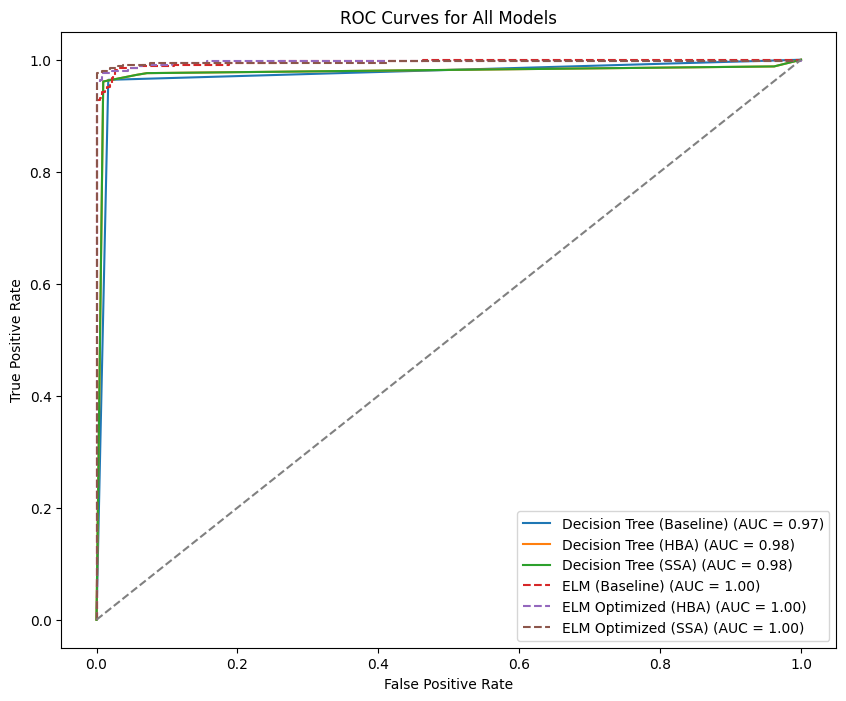

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curves():
    models = [
        ('Decision Tree (Baseline)', dt, X_test),
        ('Decision Tree (HBA)', dt_hba, X_test),
        ('Decision Tree (SSA)', clf_ssa, X_test),
    ]
    elm_models = [
        ('ELM (Baseline)', elm, X_test),
        ('ELM Optimized (HBA)', elm_hba, X_test),
        ('ELM Optimized (SSA)', elm_ssa, X_test)
    ]

    plt.figure(figsize=(10,8))

    # For sklearn models
    for name, model, Xdata in models:
        proba = model.predict_proba(Xdata)[:,1]
        fpr, tpr, _ = roc_curve(y_test, proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

    # For ELM models, obtain sigmoid predictions before thresholding
    for name, elm_model, Xdata in elm_models:
        proba = elm_model._activation(np.dot(Xdata, elm_model.input_weights) + elm_model.bias).dot(elm_model.output_weights).flatten()
        fpr, tpr, _ = roc_curve(y_test, proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, linestyle='--', label=f'{name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for All Models')
    plt.legend()
    plt.show()

plot_roc_curves()


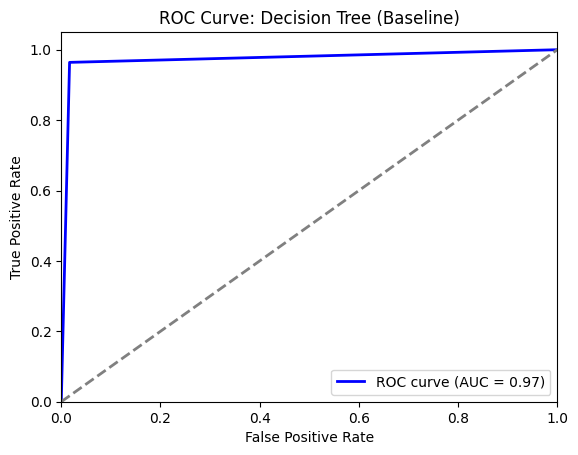

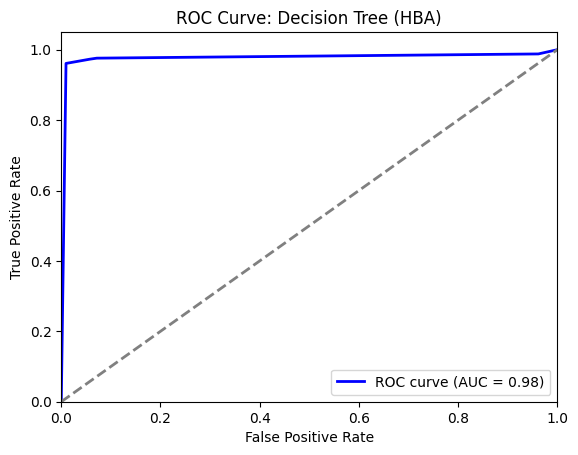

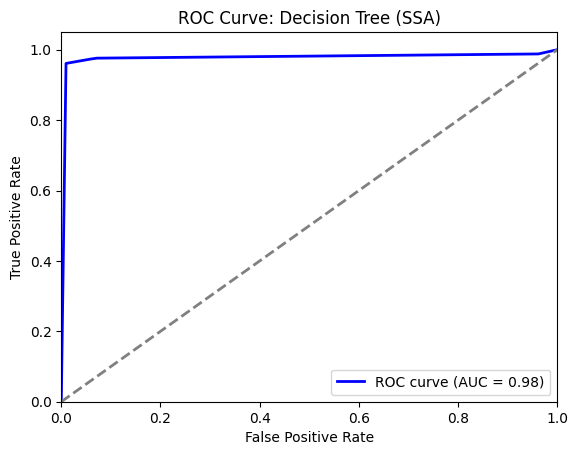

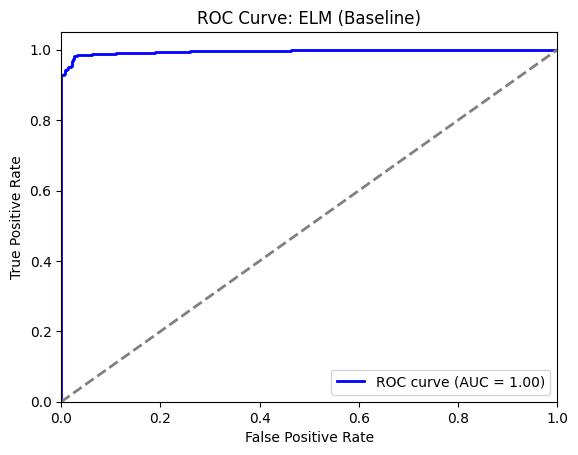

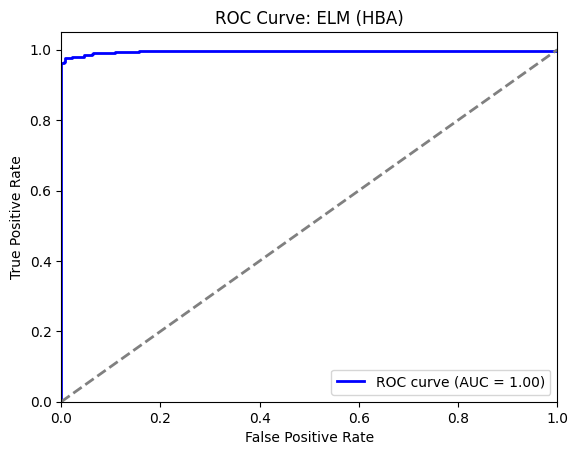

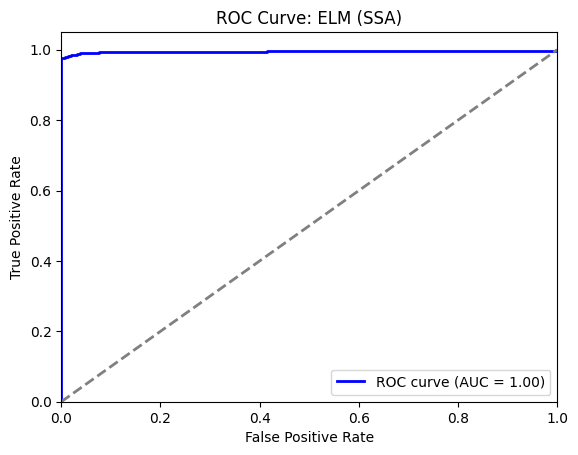

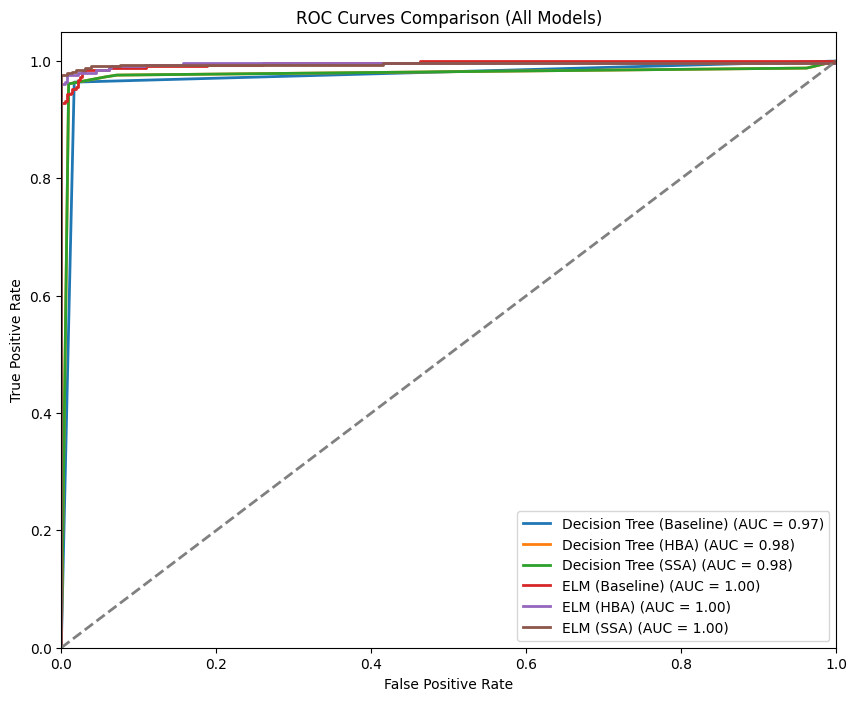

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

#--- Utility: For each model output, get probability/sigmoid output ---
def get_elm_prob(elm_model, X):
    # Uses the raw sigmoid output for ROC/AUC computation
    H = elm_model._activation(np.dot(X, elm_model.input_weights) + elm_model.bias)
    prob = np.dot(H, elm_model.output_weights).flatten()
    return prob

#--- ROC for each model, separate plots ---
model_curve_info = [
    ('Decision Tree (Baseline)', dt, dt.predict_proba(X_test)[:,1]),
    ('Decision Tree (HBA)', dt_hba, dt_hba.predict_proba(X_test)[:,1]),
    ('Decision Tree (SSA)', clf_ssa, clf_ssa.predict_proba(X_test)[:,1]),
    ('ELM (Baseline)', elm, get_elm_prob(elm, X_test)),
    ('ELM (HBA)', elm_hba, get_elm_prob(elm_hba, X_test)),
    ('ELM (SSA)', elm_ssa, get_elm_prob(elm_ssa, X_test)),
]

# Individual ROC Curves
for name, model, probs in model_curve_info:
    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve: {name}')
    plt.legend(loc='lower right')
    plt.show()

# Combined ROC Curve for all 6 models
plt.figure(figsize=(10,8))
for name, model, probs in model_curve_info:
    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison (All Models)')
plt.legend(loc='lower right')
plt.show()
